In [1]:
import json
import os
import ast
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import cv2

from sklearn.metrics import confusion_matrix


In [2]:
def plot_confusion_matrix(target, predicted, title, normalize):
    # Create confusion matrix
    cm = confusion_matrix(target, predicted, normalize=normalize)
    
    # Get labels
    all_labels = np.unique(np.concatenate((target, predicted)))
    
    # Create DataFrame for confusion matrix
    cm_df = pd.DataFrame(cm, index=all_labels, columns=all_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=False, cmap='Blues', fmt='g')
    plt.title(f'{title}, norm by {normalize}')
    plt.xlabel('Pred')
    plt.ylabel('True')
    plt.show()


In [3]:
def exp_iterator(base_dir="outputs", return_train=False):
    sorted_dates = sorted(os.listdir(base_dir), key = lambda date: datetime.strptime(date, "%Y-%m-%d"))
    for exp_date in sorted_dates:
        exp_date_dir = os.path.join(base_dir, exp_date)
        sorted_time = sorted(os.listdir(exp_date_dir), key = lambda date: datetime.strptime(date, "%H-%M-%S"))
        for exp_time in sorted_time:
            exp_dir = os.path.join(exp_date_dir, exp_time)
            exp_test_dir = os.path.join(exp_dir, "test")
            if not os.path.exists(exp_test_dir):
                print(exp_test_dir, "does not exist")
                continue
            for stats_name in os.listdir(exp_test_dir):
                if not return_train and stats_name == "train_val.csv":
                    continue
                stats_path = os.path.join(exp_test_dir, stats_name)
                yield stats_path

def draw_sample(df):
    random_row = df.sample(n=1)
    
    # Convert the "path" column value to a string
    img_path = str(random_row["path"].values[0])
    # Read the image
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image
    plt.imshow(img)
    plt.title(f"Path: {img_path}\nTarget:{random_row['target'].values[0]}\nPred: {random_row['predict'].values[0]}")
    plt.show()


def draw_samples(df):    
    size = 2
    df = df.sample(n=size**2)
    
    fig, axes = plt.subplots(size, size, figsize=(12, 12))
    for (index, row), ax in zip(df.iterrows(), axes.flatten()):
        image = cv2.imread(row["path"])
        ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax.set_title(f"Target: {row['target']}\nPred: {row['predict']}\n")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

In [4]:
for stats_path in exp_iterator():
    print(stats_path)

outputs/2024-02-18/23-47-21/test/val.csv
outputs/2024-02-19/02-17-21/test/val.csv
outputs/2024-02-20/21-38-09/test/val.csv
outputs/2024-02-21/00-07-38/test/val.csv
outputs/2024-02-22/22-40-07/test/val.csv


In [5]:
weighted_accs = []
accs = []
attr_accs = []
correcntesses = []
experiments = []

for i, path in enumerate(exp_iterator()):
    date, time = path.split("/")[1:3]
    experiments.append("\n" + f"{date}_{time}" if i % 2 == 0 else f"{date}_{time}")
    
    df = pd.read_csv(path)
    df["target"] = df["target"].apply(ast.literal_eval)
    df["predict"] = df["predict"].apply(ast.literal_eval)
    df["main_class"] = df["target"].apply(lambda x: x[0])
    correctness = df["is_correct"].mean()
    
    weighted_acc = df.groupby("main_class", as_index=False).agg({"main_type_acc": "mean"})["main_type_acc"].mean()
    acc = df["main_type_acc"].mean()

    target_attr = df["target"].apply(lambda x: x[1:])
    pred_attr = df["predict"].apply(lambda x: x[1:])
    
    attr_acc = []
    for i in range(len(pred_attr)):
        targ = target_attr[i]
        pred = pred_attr[i]
        cur_attrs = [targ[i] == pred[i] if i < len(pred) else False for i in range(len(targ))]
        attr_acc.append(cur_attrs.count(True)/len(targ))
    
    attr_acc = pd.Series(attr_acc).mean()
    
    print(f"Weighted acc: {weighted_acc:.3f}")
    print(f"Acc: {acc:.3f}")
    print(f"Attr acc: {attr_acc:.3f}")
    print(f"Correctness: {correctness:.3f}")
    
    weighted_accs.append(weighted_acc)
    accs.append(acc)
    attr_accs.append(attr_acc)
    correcntesses.append(correctness)
    print()



Weighted acc: 0.901
Acc: 0.929
Attr acc: 0.799
Correctness: 1.000

Weighted acc: 0.875
Acc: 0.930
Attr acc: 0.792
Correctness: 1.000

Weighted acc: 0.908
Acc: 0.931
Attr acc: 0.807
Correctness: 1.000

Weighted acc: 0.862
Acc: 0.932
Attr acc: 0.808
Correctness: 1.000

Weighted acc: 0.912
Acc: 0.924
Attr acc: 0.789
Correctness: 1.000



In [6]:
pd.DataFrame({
    "Experiment": list(map(lambda x: x.strip(), experiments)),
    "Main Accuracy": accs,
    "Attribute Accuracy": attr_accs,
    "Correctness": correctness
})

,Experiment,Main Accuracy,Attribute Accuracy,Correctness
0,2024-02-18_23-47-21,0.929153,0.798723,1.0
1,2024-02-19_02-17-21,0.930169,0.792412,1.0
2,2024-02-20_21-38-09,0.931186,0.807492,1.0
3,2024-02-21_00-07-38,0.932203,0.808452,1.0
4,2024-02-22_22-40-07,0.924068,0.789449,1.0


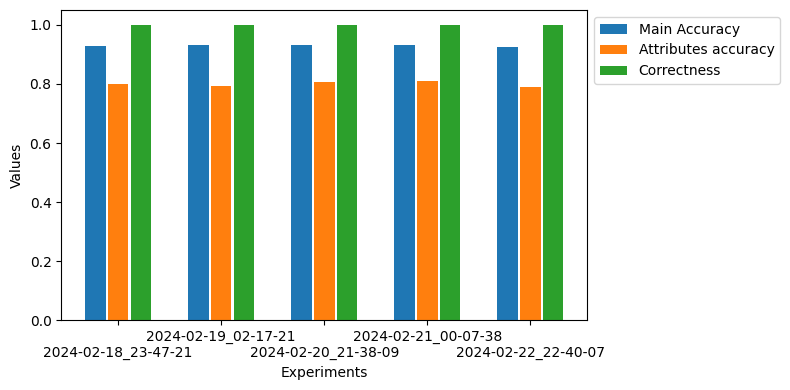

In [7]:
x = np.arange(5)
width = 0.2 

fig, ax = plt.subplots()
fig.set_size_inches(8, 4)  # Устанавливаем ширину в 12 дюймов и высоту в 8 дюймов
rects1 = ax.bar(x - width * 1.1, accs, width, label='Main Accuracy')
rects2 = ax.bar(x, attr_accs, width, label='Attributes accuracy')
rects3 = ax.bar(x + width * 1.1, correcntesses, width, label='Correctness')

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


ax.set_xlabel('Experiments')
ax.set_ylabel('Values')
ax.set_title('')
ax.set_xticks(x)
ax.set_xticklabels(experiments)

ax.legend()

ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Устанавливаем макет, чтобы учесть дополнительное место для легенды
fig.tight_layout()

plt.show()

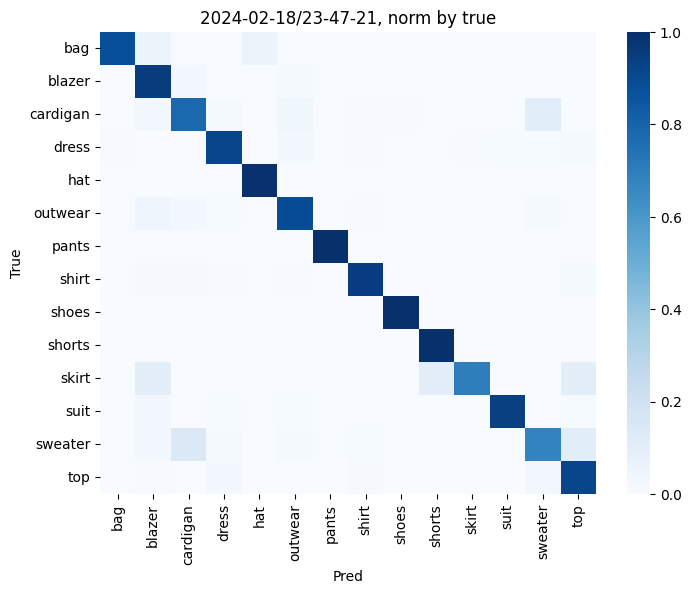

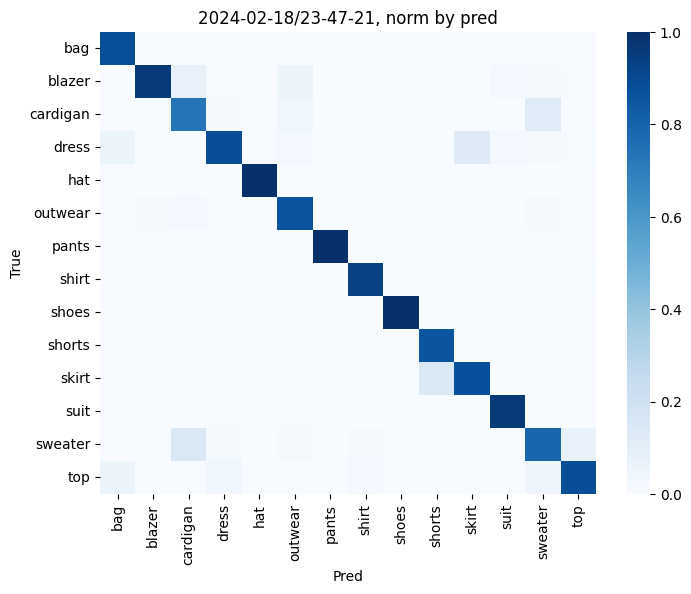

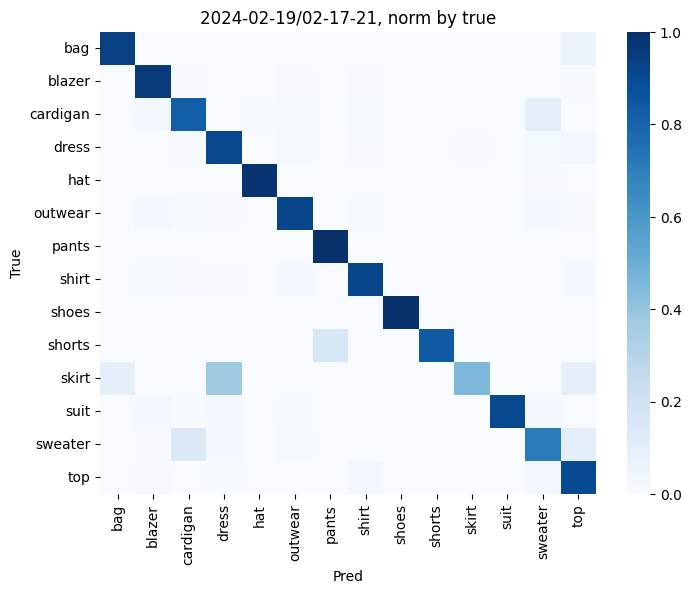

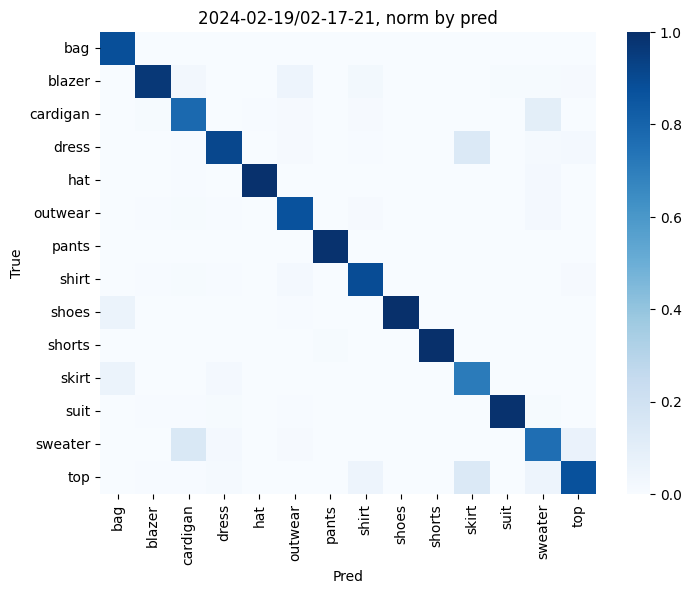

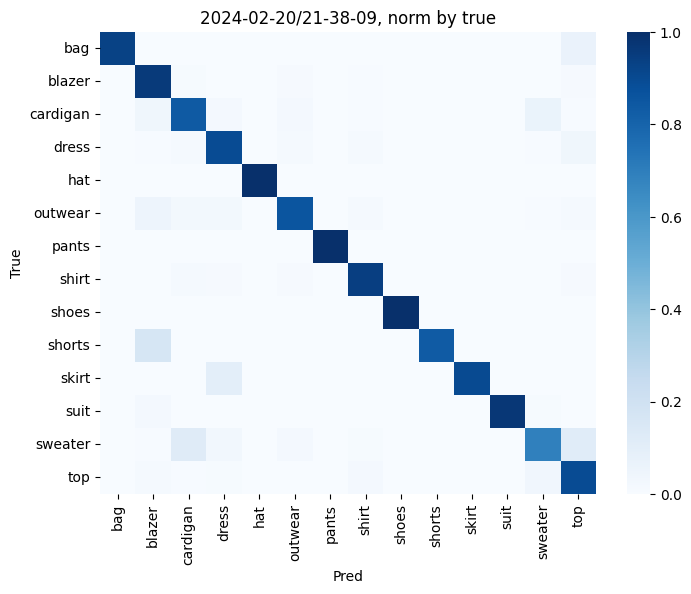

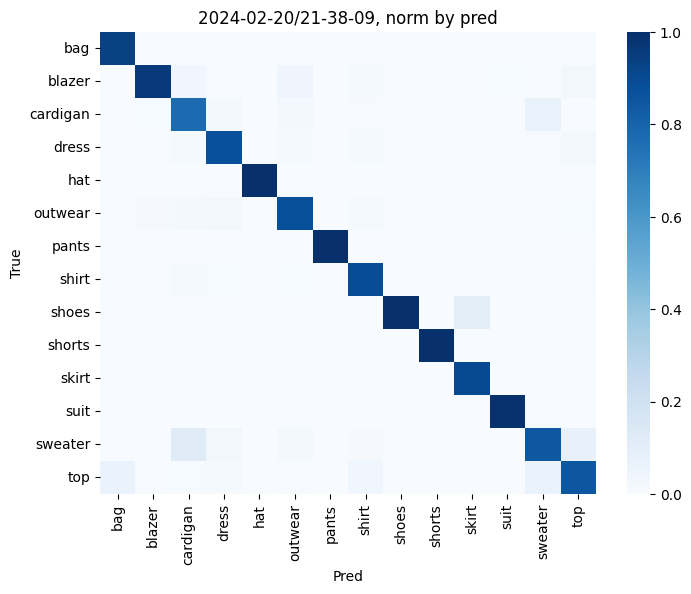

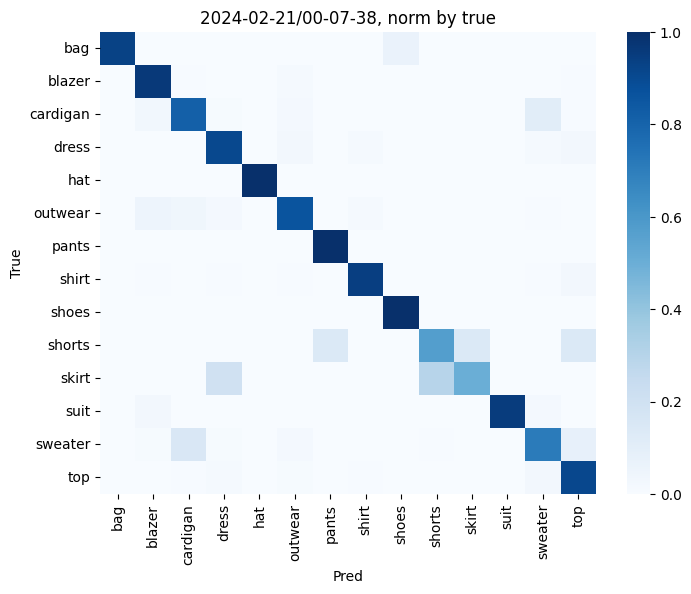

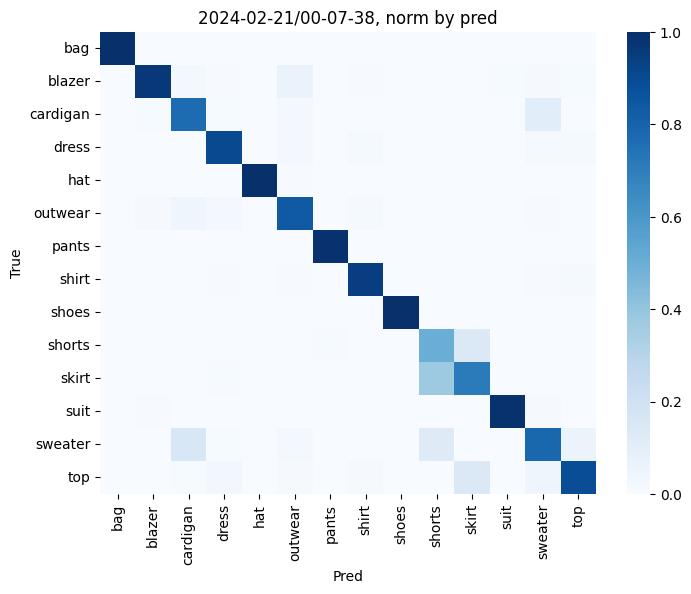

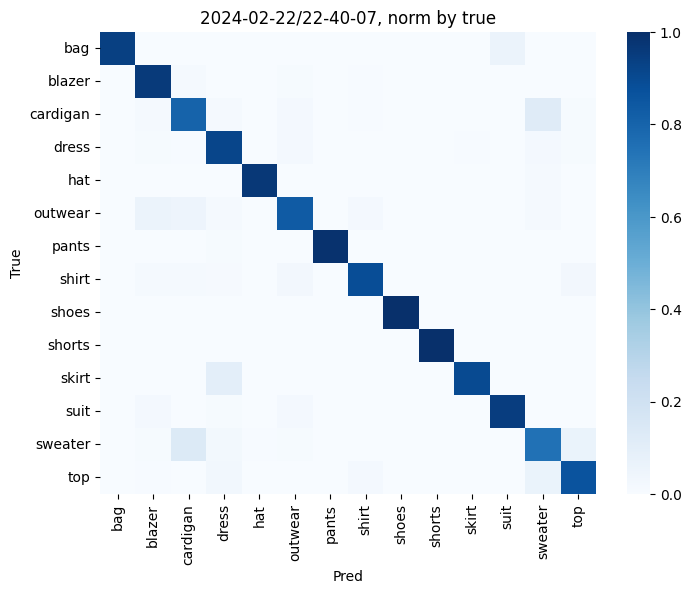

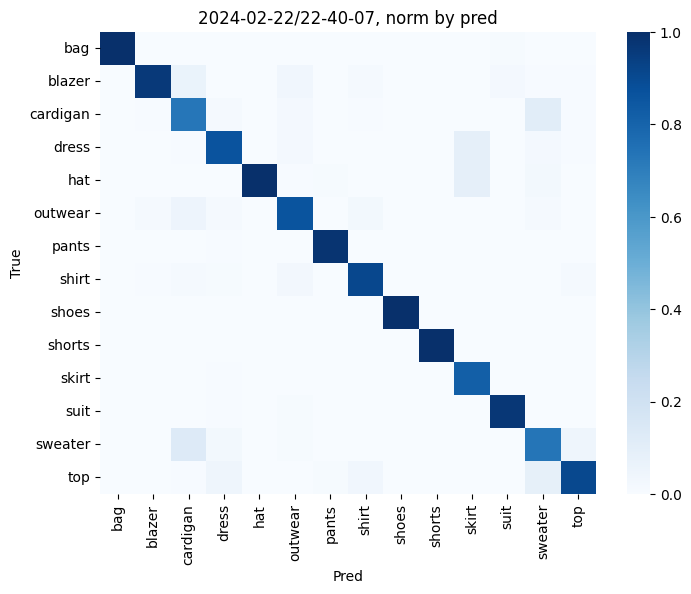

In [8]:
for path in exp_iterator():
    df = pd.read_csv(path)
    df["target"] = df["target"].apply(ast.literal_eval)
    df["predict"] = df["predict"].apply(ast.literal_eval)
    main_cls_target = df["target"].apply(lambda x: x[0])
    main_cls_pred = df["predict"].apply(lambda x: x[0])
    date, time = path.split("/")[1:3]
    plot_confusion_matrix(main_cls_target, main_cls_pred, f"{date}/{time}", "true")
    plot_confusion_matrix(main_cls_target, main_cls_pred, f"{date}/{time}", "pred")

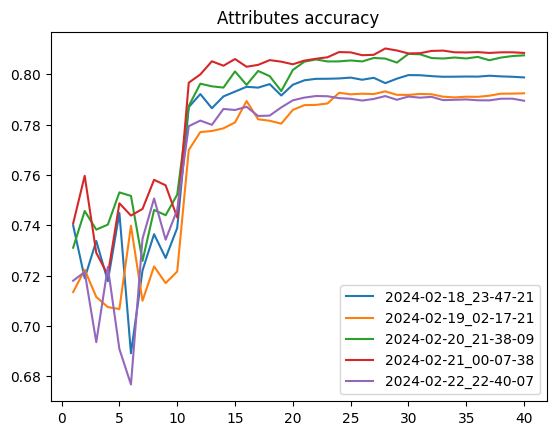

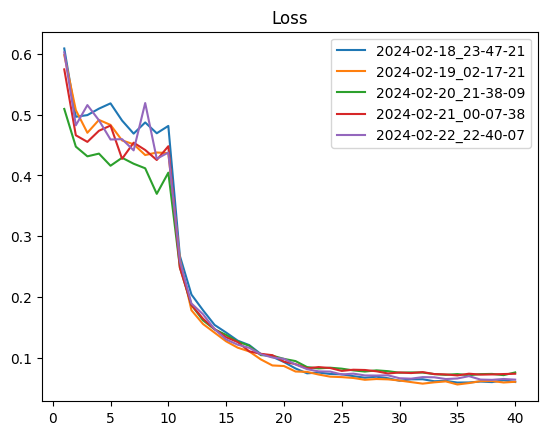

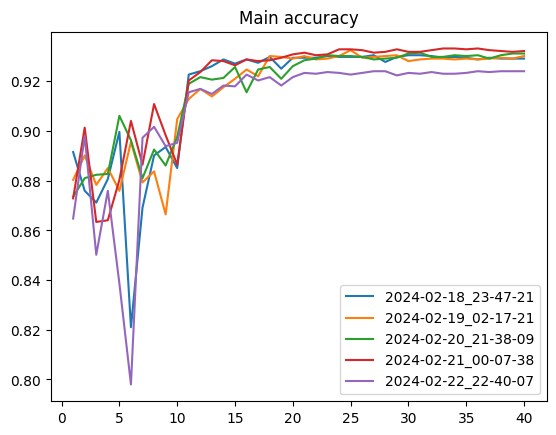

In [9]:
for dir, name in zip(
    ["attrs_acc", "loss", "main_acc"],
    ["Attributes accuracy", "Loss", "Main accuracy"]
):
    for _ in exp_iterator():
        date, time = _.split("/")[1:3]
        path = os.path.join("runs", dir, f"{date}_{time}.csv")
        df = pd.read_csv(path)
        plt.plot(df["Step"], df["Value"], label=f"{date}_{time}")
    
    plt.title(name)
    plt.legend()
    plt.show()


In [11]:
# path = "outputs/2024-02-14/23-23-30/test/val.csv"

# df = pd.read_csv(path)
# df["target"] = df["target"].apply(ast.literal_eval)
# df["predict"] = df["predict"].apply(ast.literal_eval)
# df

<h1> Wrong main class </h1>

In [ ]:
main_cls_target = df["target"].apply(lambda x: x[0])
main_cls_pred = df["predict"].apply(lambda x: x[0])
wrong_main_cls_df = df[main_cls_pred != main_cls_target]

In [ ]:
plot_confusion_matrix(main_cls_target, main_cls_pred)

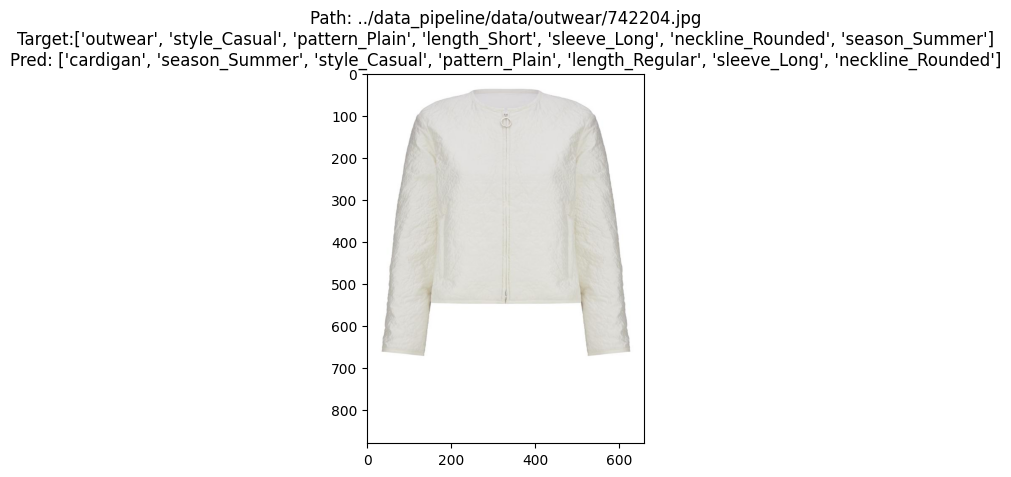

In [14]:
draw_sample(wrong_main_cls_df)

<h1> Correctness check </h1>

In [21]:
wrong_df = df[df["is_correct"] == 0]
wrong_df.shape

(5, 6)

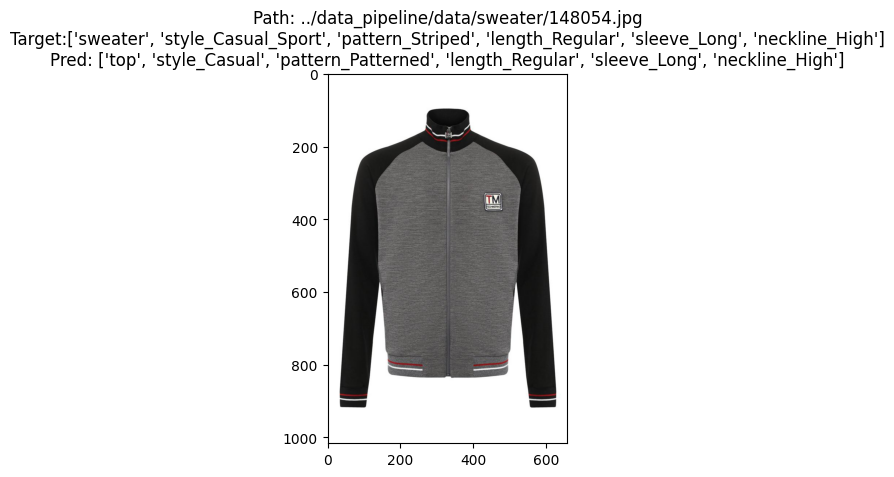

In [36]:
draw_sample(wrong_df)